### 🩻 Pneumonia Detection from Chest X-Rays using Deep Learning

Pneumonia is one of the most common and serious respiratory illnesses globally, and early, accurate diagnosis is critical for effective treatment. Traditionally, radiologists examine chest X-rays to detect pneumonia—however, this process can be time-consuming and subjective. With the help of AI, we can accelerate and support this diagnostic process by training models to automatically detect pneumonia from X-ray images.

In this project, your role as a data science consultant involves evaluating the effectiveness of a deep learning model in distinguishing between normal and pneumonia-affected lungs using chest X-rays.

You will fine-tune a pre-trained **ResNet-18** convolutional neural network to classify chest X-ray images into two categories:
- **NORMAL** (healthy lungs)
- **PNEUMONIA** (infected lungs)

By leveraging the pre-trained weights of ResNet-18, you can train an accurate classifier with minimal computational effort and reduced training time.

---

### 📁 The Data

<img src="x-rays_sample.png" align="center"/>
&nbsp

The dataset contains chest X-ray images already formatted for use with ResNet-18. Above, you can see a sample of 5 images from each class.

After unzipping the `chestxrays.zip` archive, you will find the dataset organized under `data/chestxrays`, divided into two folders:
- `train` – for training the model
- `test` – for evaluating the model

Each class (NORMAL and PNEUMONIA) contains:
- **150 images** for training
- **50 images** for testing  
(For a total of **300 training** and **100 testing** images)

The dataset has been conveniently loaded into PyTorch `DataLoader` objects named `train_loader` and `test_loader`, making it easy to feed the data into your model during training and evaluation.

In [1]:
import random
import numpy as np
from torchvision.transforms import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# Train model
import torch
from torchvision import models
import torch.nn as nn
import torch.optim as optim

# Evaluate model
from torchmetrics import Accuracy, F1Score

# Set random seeds for reproducibility
torch.manual_seed(101010)
np.random.seed(101010)
random.seed(101010)

In [2]:
import os
import zipfile

# Unzip the data folder
if not os.path.exists('data/chestxrays'):
    with zipfile.ZipFile('data/chestxrays.zip', 'r') as zip_ref:
        zip_ref.extractall('data')

In [3]:
# Define the transformations to apply to the images for use with ResNet-18
transform_mean = [0.485, 0.456, 0.406]
transform_std =[0.229, 0.224, 0.225]
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize(mean=transform_mean, std=transform_std)])

# Apply the image transforms
train_dataset = ImageFolder('data/chestxrays/train', transform=transform)
test_dataset = ImageFolder('data/chestxrays/test', transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=len(train_dataset) // 2, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset))

Load and Adjust the ResNet-18 Model

In [4]:
from torchvision.models import resnet18, ResNet18_Weights

# Load the pre-trained ResNet-18 model
resnet18 = resnet18(weights=ResNet18_Weights.DEFAULT)

# Freeze all layers to prevent updates during training
for param in resnet18.parameters():
    param.requires_grad = False

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/repl/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Adjusting the Final Layer

In [5]:
# Get the number of input features to the last FC layer
num_features = resnet18.fc.in_features

# Replace the final layer for binary classification
resnet18.fc = nn.Linear(num_features, 1)

Define the Loss Function and Optimizer

In [6]:
# Use binary cross-entropy with logits for binary classification
criterion = nn.BCEWithLogitsLoss()

# Only update the final fully connected layer's parameters
optimizer = optim.Adam(resnet18.fc.parameters(), lr=0.01)

Training Loop

In [32]:
# Move model to device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet18.to(device)

# Train the model
epochs = 50
resnet18.train()

for epoch in range(epochs):
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = resnet18(inputs)

        # Compute loss
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss:.4f}")

Epoch 1/50, Loss: 0.0750
Epoch 2/50, Loss: 0.0745
Epoch 3/50, Loss: 0.0704
Epoch 4/50, Loss: 0.0766
Epoch 5/50, Loss: 0.0704
Epoch 6/50, Loss: 0.0683
Epoch 7/50, Loss: 0.0684
Epoch 8/50, Loss: 0.0724
Epoch 9/50, Loss: 0.0693
Epoch 10/50, Loss: 0.0855
Epoch 11/50, Loss: 0.0634
Epoch 12/50, Loss: 0.0646
Epoch 13/50, Loss: 0.0672
Epoch 14/50, Loss: 0.0648
Epoch 15/50, Loss: 0.0623
Epoch 16/50, Loss: 0.0725
Epoch 17/50, Loss: 0.0635
Epoch 18/50, Loss: 0.0777
Epoch 19/50, Loss: 0.0593
Epoch 20/50, Loss: 0.0592
Epoch 21/50, Loss: 0.0623
Epoch 22/50, Loss: 0.0591
Epoch 23/50, Loss: 0.0584
Epoch 24/50, Loss: 0.0566
Epoch 25/50, Loss: 0.0575
Epoch 26/50, Loss: 0.0665
Epoch 27/50, Loss: 0.0593
Epoch 28/50, Loss: 0.0535
Epoch 29/50, Loss: 0.0550
Epoch 30/50, Loss: 0.0576
Epoch 31/50, Loss: 0.0533
Epoch 32/50, Loss: 0.0541
Epoch 33/50, Loss: 0.0523
Epoch 34/50, Loss: 0.0516
Epoch 35/50, Loss: 0.0742
Epoch 36/50, Loss: 0.0927
Epoch 37/50, Loss: 0.0538
Epoch 38/50, Loss: 0.0550
Epoch 39/50, Loss: 0.

### Below is the provided model evaluation code. Run the below cell to help you evaluate the accuracy and F1-score of your fine-tuned model.

Evaluate the Model

In [33]:
# Set model to evaluation mode
model = resnet18
model.eval()

# Initialize metrics for accuracy and F1 score
accuracy_metric = Accuracy(task="binary")
f1_metric = F1Score(task="binary")

# Create lists store all predictions and labels
all_preds = []
all_labels = []

# Disable gradient calculation for evaluation
with torch.no_grad():
  for inputs, labels in test_loader:
    # Forward pass
    outputs = model(inputs)
    preds = torch.sigmoid(outputs).round()  # Round to 0 or 1

    # Extend the lists with predictions and labels
    all_preds.extend(preds.tolist())
    all_labels.extend(labels.unsqueeze(1).tolist())

    # Convert lists back to tensors
    all_preds = torch.tensor(all_preds)
    all_labels = torch.tensor(all_labels)

    # Calculate accuracy and F1 score
    test_acc = accuracy_metric(all_preds, all_labels).item()
    test_f1 = f1_metric(all_preds, all_labels).item()

print(f"Test Accuracy: {test_acc}")
print(f"Test F1 Score: {test_f1}")

Test Accuracy: 0.7699999809265137
Test F1 Score: 0.8130081295967102


Balanced Prediction Visualization from Test Set

In [34]:
def predict_and_show_balanced(model, dataloader, num_per_class=3):
    model.eval()
    shown = {"NORMAL": 0, "PNEUMONIA": 0}
    class_names = test_dataset.classes  # ['NORMAL', 'PNEUMONIA']

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = torch.sigmoid(outputs).round().squeeze(1).cpu().numpy()
            labels = labels.cpu().numpy()

            for i in range(inputs.size(0)):
                true_label = class_names[int(labels[i])]
                if shown[true_label] >= num_per_class:
                    continue  # skip if we already showed enough for this class

                image = inputs[i].cpu()
                image = image * torch.tensor(transform_std).view(3,1,1) + torch.tensor(transform_mean).view(3,1,1)
                image = image.permute(1, 2, 0).numpy()
                image = (image * 255).astype("uint8")

                pred_label = class_names[int(preds[i])]

                plt.imshow(image, cmap='gray')
                plt.title(f"Predicted: {pred_label} | Actual: {true_label}")
                plt.axis('off')
                plt.show()

                shown[true_label] += 1

                # Stop if we’ve shown enough from both classes
                if all(v >= num_per_class for v in shown.values()):
                    return

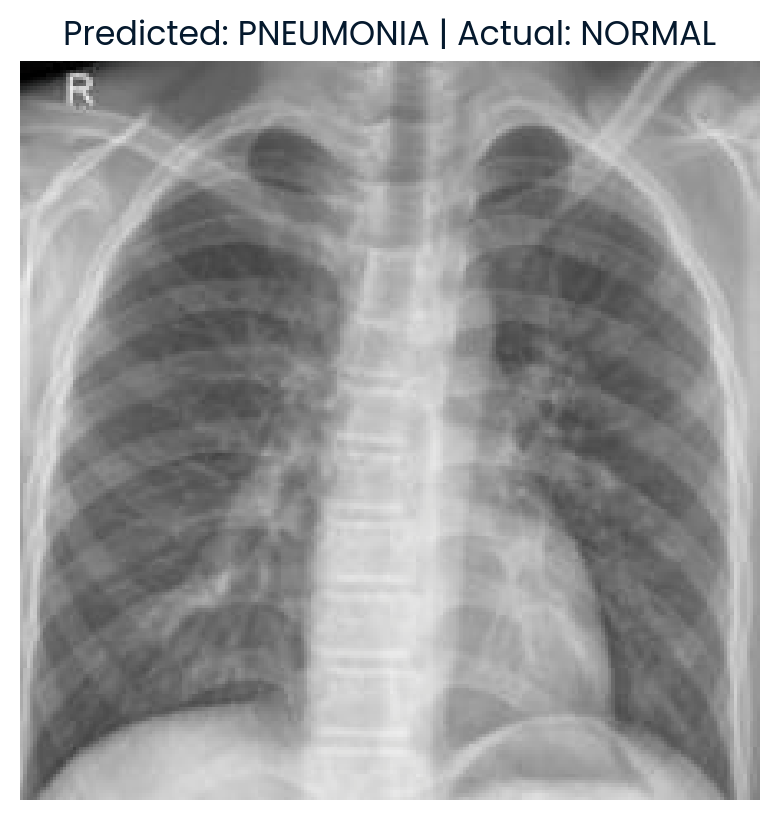

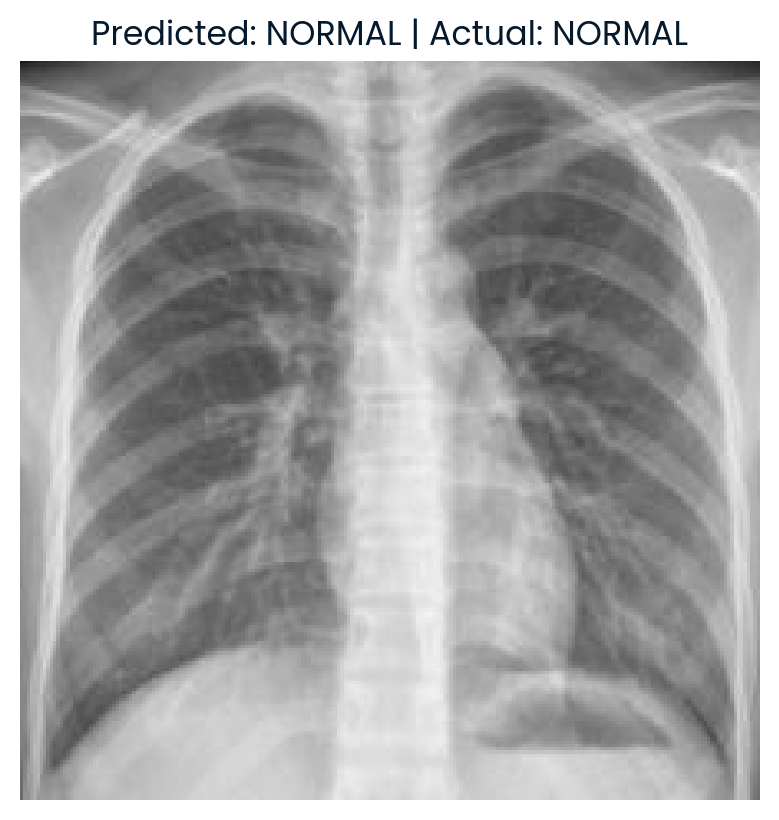

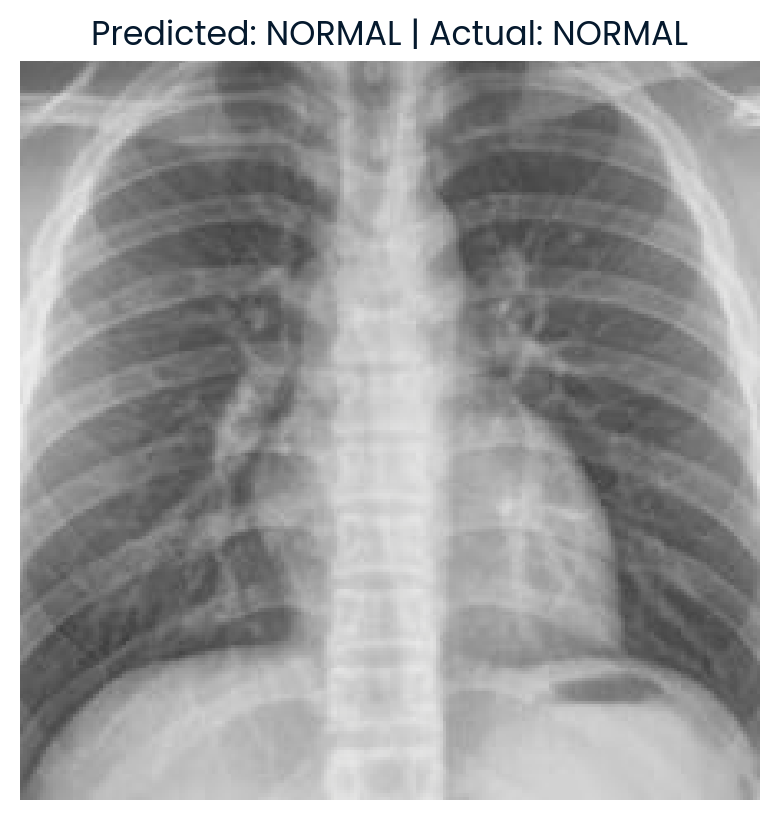

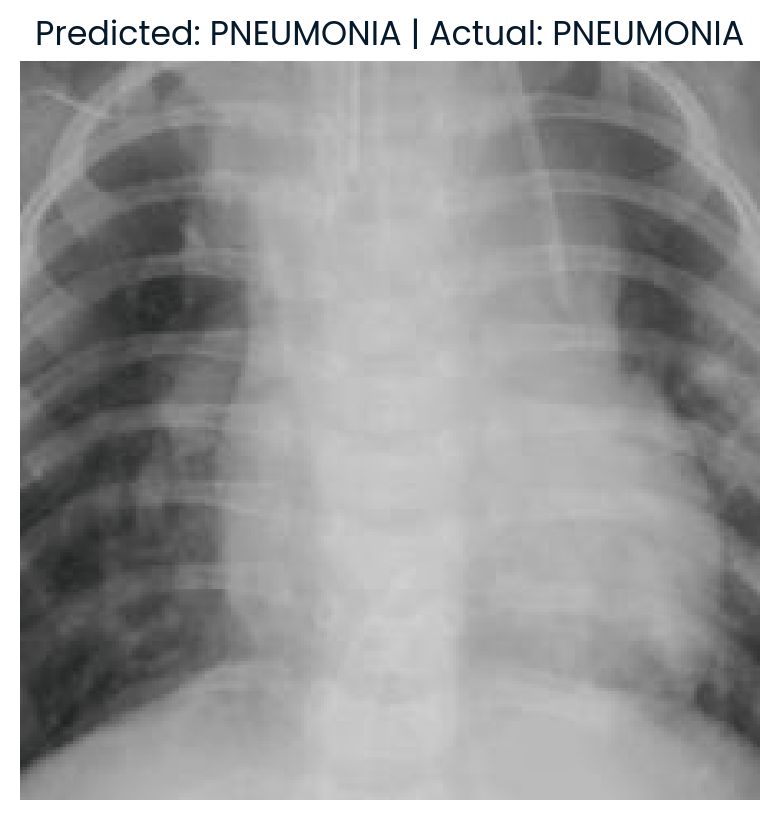

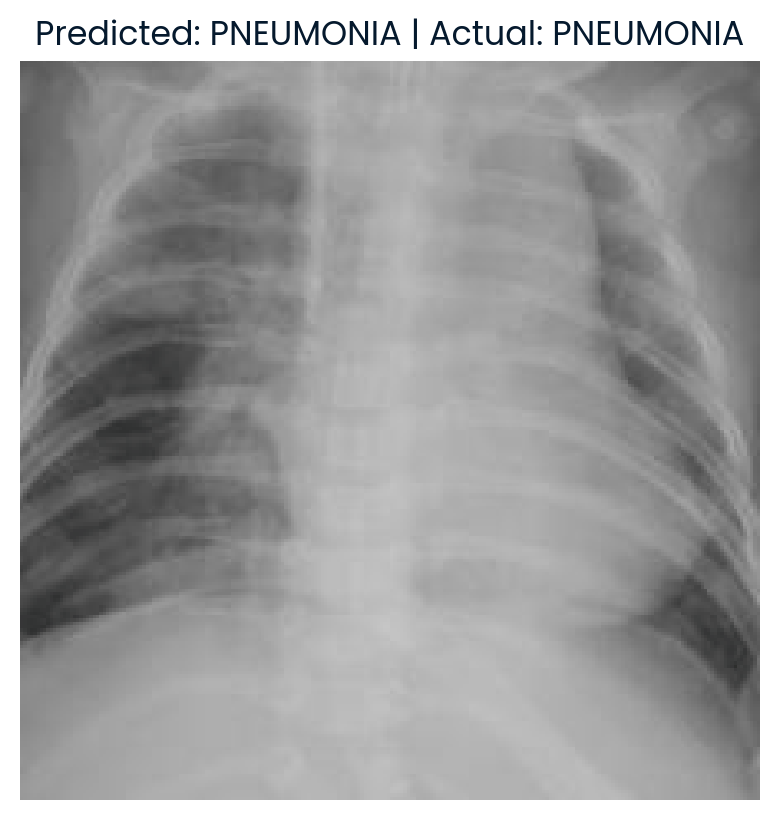

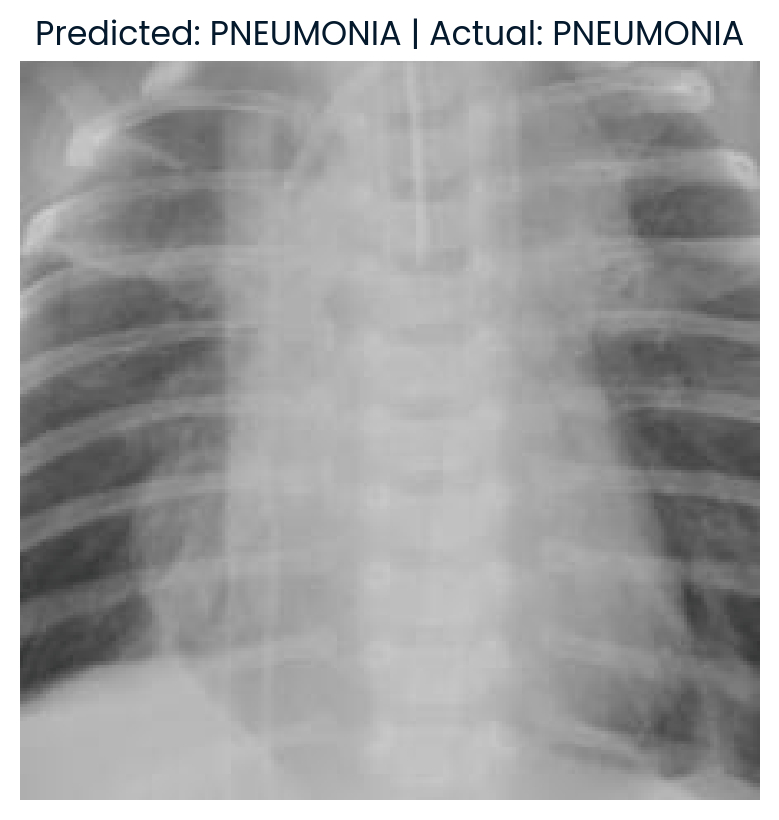

In [35]:
predict_and_show_balanced(resnet18, test_loader, num_per_class=3)

Predict on Custom External Images

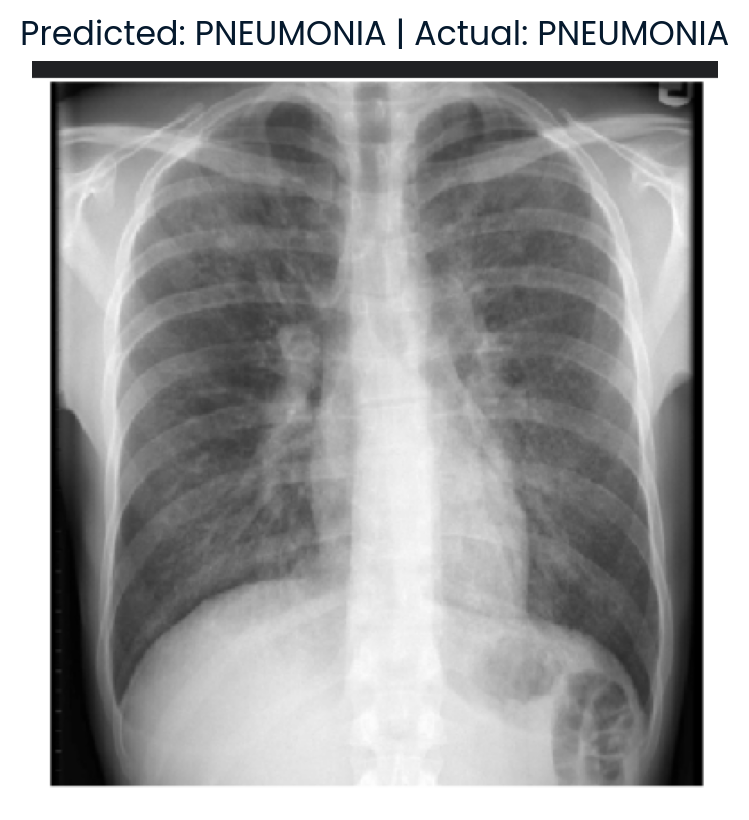

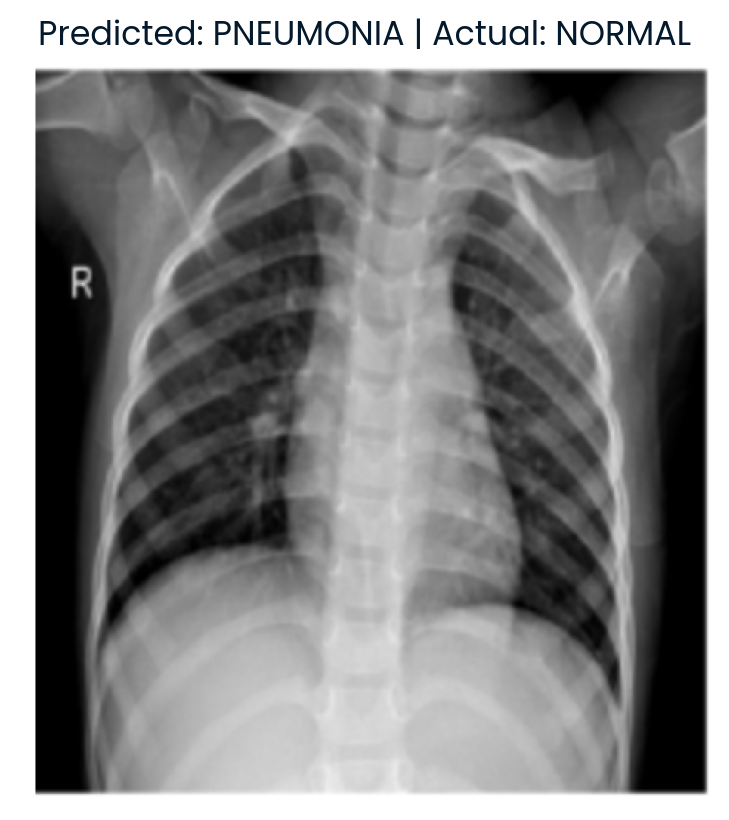

In [36]:
from PIL import Image
import os
import torch
import matplotlib.pyplot as plt

# Path to custom image folder
custom_img_dir = 'images_form_other_dataset'

# Class mapping (adjust if needed)
class_names = ['NORMAL', 'PNEUMONIA']

# Function to load and preprocess a single image
def load_and_predict_image(img_path, model):
    image = Image.open(img_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(input_tensor)
        pred = torch.sigmoid(output).round().item()
        
    return int(pred), image

# Iterate through each image and predict
for img_name in os.listdir(custom_img_dir):
    if not img_name.endswith('.png'):
        continue

    img_path = os.path.join(custom_img_dir, img_name)
    predicted_class_idx, raw_img = load_and_predict_image(img_path, resnet18)

    # Extract actual label from filename (e.g., 'normal1.png' → NORMAL)
    actual_label = 'NORMAL' if 'normal' in img_name.lower() else 'PNEUMONIA'
    predicted_label = class_names[predicted_class_idx]

    # Show the image and prediction
    plt.imshow(raw_img, cmap='gray')
    plt.title(f"Predicted: {predicted_label} | Actual: {actual_label}")
    plt.axis('off')
    plt.show()